In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [76]:
n_obs = 4000
n_loci = 200
n_pop = 4

In [77]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

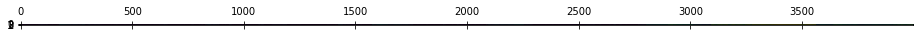

In [78]:
plt.matshow(true_ind_admix_propn.T)

In [79]:
g_obs.shape

(4000, 200, 3)

# Get prior

In [80]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [81]:
k_approx = 12

In [82]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [83]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (200, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (4000, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [84]:
t0 = time.time()
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

print('init time: {:.03f}sec'.format(time.time() - t0))

vb_params_init_dict = deepcopy(vb_params_dict)

init time: 0.649sec


In [85]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

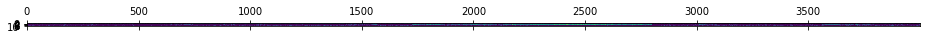

In [86]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [87]:
## get initial e_z
t0 = time.time()
e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(g_obs, \
                                    vb_params_dict, use_logitnormal_sticks)

e_z_init = cavi_lib.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                e_log_1m_pop_freq)

print('e_z_init time: {:.03f}sec'.format(time.time() - t0))

e_z_init time: 1.433sec


# Run CAVI

In [88]:
ez_opt_cavi, vb_svi_cavi, kl_vec_cavi, time_vec_cavi = \
    cavi_lib.run_cavi(g_obs, deepcopy(vb_params_init_dict), 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 20,
                        x_tol = 1e-2)


iteration [1]; kl:1809037.421925; elapsed: 6.279secs
iteration [2]; kl:1432442.077291; elapsed: 6.0878secs
iteration [3]; kl:1284164.569821; elapsed: 6.049secs
iteration [4]; kl:1188776.047872; elapsed: 7.1732secs
iteration [5]; kl:1135784.367213; elapsed: 7.8978secs
iteration [6]; kl:1112087.419757; elapsed: 7.2257secs
iteration [7]; kl:1101276.034067; elapsed: 6.5603secs
iteration [8]; kl:1095515.98674; elapsed: 7.2574secs
iteration [9]; kl:1091793.196043; elapsed: 6.7505secs
iteration [10]; kl:1089042.318731; elapsed: 6.465secs
iteration [11]; kl:1086853.885373; elapsed: 6.2614secs
iteration [12]; kl:1085039.558368; elapsed: 6.1552secs
iteration [13]; kl:1083496.741633; elapsed: 6.1137secs
iteration [14]; kl:1082162.10286; elapsed: 6.14secs
iteration [15]; kl:1080992.853569; elapsed: 6.0914secs
iteration [16]; kl:1079958.154057; elapsed: 6.1889secs
iteration [17]; kl:1079034.693854; elapsed: 6.1941secs
iteration [18]; kl:1078204.188323; elapsed: 6.1161secs
iteration [19]; kl:1077451

In [89]:
ez_opt_svi, vb_svi_dict, kl_vec_svi, time_vec_svi = \
    cavi_lib.run_svi(g_obs, deepcopy(vb_params_init_dict),
                prior_params_dict,
                e_z_init,
                use_logitnormal_sticks,
                batchsize = round(n_obs / 10),
                x_tol = 1e-2,
                max_iter = 200,
                print_every = 10, 
                local_x_tol = 1e16)

iteration [10]; kl:1858851.502966; elapsed: 6.1423secs
iteration [20]; kl:1403440.79344; elapsed: 6.095secs
iteration [30]; kl:1211387.932938; elapsed: 6.0892secs
iteration [40]; kl:1143473.889539; elapsed: 6.093secs
iteration [50]; kl:1110042.661065; elapsed: 6.3603secs
iteration [60]; kl:1097582.611241; elapsed: 6.1817secs
iteration [70]; kl:1093473.727607; elapsed: 6.1057secs
iteration [80]; kl:1088955.263322; elapsed: 6.1076secs
iteration [90]; kl:1086955.489058; elapsed: 6.1065secs
iteration [100]; kl:1085351.678117; elapsed: 6.1039secs
iteration [110]; kl:1083989.371401; elapsed: 6.0652secs
iteration [120]; kl:1082880.855073; elapsed: 6.0992secs
iteration [130]; kl:1081935.169438; elapsed: 6.0815secs
iteration [140]; kl:1081113.173439; elapsed: 6.1101secs
iteration [150]; kl:1080389.764962; elapsed: 6.1495secs
iteration [160]; kl:1079750.751735; elapsed: 6.1403secs
iteration [170]; kl:1079176.458097; elapsed: 6.764secs
iteration [180]; kl:1078666.976818; elapsed: 6.6042secs
itera

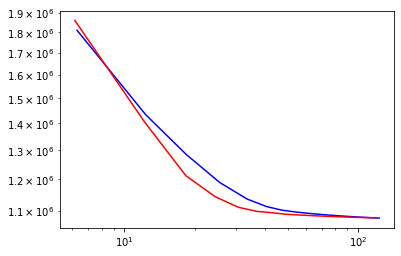

In [90]:
plt.loglog(time_vec_cavi[1:], kl_vec_cavi, 'b')
plt.loglog(time_vec_svi[1:], kl_vec_svi, 'r')

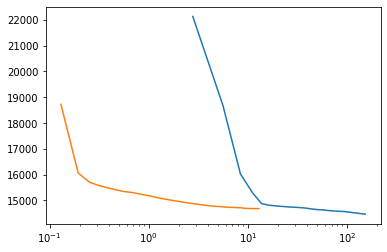

In [39]:
plt.semilogx(time_vec_svi[1:], kl_vec_svi)
plt.semilogx(time_vec_cavi[1:], kl_vec_cavi)

In [ ]:
def benchmark_one_cavi_cycle(n_obs, n_loci, n_pop, k_approx, run_cavi,  
                                vb_params_dict = None): 
    # draw data 
    g_obs, _, _ = \
        data_utils.draw_data(n_obs, n_loci, n_pop)
    
    # get prior 
    prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

    prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)
    
    # set vb_params
    use_logitnormal_sticks = False
    _, vb_params_paragami = \
        structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                        use_logitnormal_sticks = use_logitnormal_sticks)
    
    if vb_params_dict is None: 
        vb_params_dict = vb_params_paragami.random()
    
    
    if run_cavi: 
        _, _, _, time_vec = \
            cavi_lib.run_cavi(g_obs, deepcopy(vb_params_dict), 
                                prior_params_dict,
                                use_logitnormal_sticks, 
                                max_iter = 2,
                                f_tol = -1, 
                                x_tol = 1e-2)
    else: 
        # run svi 
        _ = cavi_lib.run_svi(g_obs, deepcopy(vb_params_dict),
                prior_params_dict,
                e_z_init = np.random.rand((n_obs, n_loci, k_approx + 1, 2)),
                use_logitnormal_sticks = use_logitnormal_sticks,
                batchsize = 1,
                x_tol = 1e-2,
                max_iter = 2,
                print_every = 1)
        
    return time_vec[1], vb_params_dict